In [1]:
%matplotlib widget
# ==== 1) load packages ====
import numpy as np
import pandas as pd
import math
import glob
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import StandardScaler
import torch
import os
os.chdir(
    # "/home/yliu420/Project/Belief-Elicitation-on-LLM-postrelease/analysis"
    "/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis"
)
from analysis_pkg.preprocess import *
from analysis_pkg.models import *
from PCA_TSNE_scoremodel.visualization import *
from llm_belief.analysis import visualize_probability_distribution
ScoreModel = "Logit_Torch"
torch.manual_seed(2025)

In [2]:
# ==== 2) load data ====
processes = 10
## load profiles and LLM expectations to profiles and df
fl = [f"../output/{i*1000}_{(i+1)*1000}.csv" for i in range(processes)]
# combine all csv files
df = pd.concat([pd.read_csv(f) for f in fl])
profiles = pd.read_csv("../data/profiles_shuffled.csv")

In [3]:
# ==== 3) preprocess data ====
## split to Xi and Xj by odd and even rows
X = preprocess(profiles[:2000*processes])
Xi = X[0:2000*processes:2]
Xj = X[1:2000*processes:2]
y = df["profile_id"].apply(lambda x: 1 if x % 2 == 0 else -1)
y = torch.from_numpy(y.values).float()
P, d = Xi.shape

In [4]:
# ==== 4) train model, and calibration ====
split = int(0.9 * P)
ds_tr = PairwiseDataset(Xi[:split], Xj[:split], y[:split])
ds_va = PairwiseDataset(Xi[split:], Xj[split:], y[split:])
dl_tr = DataLoader(ds_tr, batch_size=64, shuffle=True, num_workers=0)
dl_va = DataLoader(ds_va, batch_size=64, shuffle=False, num_workers=0)

# model = MLPScorer(d_in=d, hidden=(256, 128), dropout=0.1)
# model = MLPAttentionScore(d_in=d, hidden=(256, 128), dropout=0.1, n_heads=2)
model = LogisticRegression(d_in=d)
model = train_pairwise(model, dl_tr, dl_va, lr=1e-3, weight_decay=1e-5, epochs=20)

## calibrate temperature
T = calibrate_temperature(model, dl_va)
print(f"Calibrated Temperature T = {T:.3f}")

[Epoch 01] train_loss=0.6710  val_loss=0.6235
[Epoch 02] train_loss=0.6055  val_loss=0.5807
[Epoch 03] train_loss=0.5669  val_loss=0.5554
[Epoch 04] train_loss=0.5423  val_loss=0.5383
[Epoch 05] train_loss=0.5248  val_loss=0.5255
[Epoch 06] train_loss=0.5112  val_loss=0.5144
[Epoch 07] train_loss=0.5001  val_loss=0.5054
[Epoch 08] train_loss=0.4908  val_loss=0.4973
[Epoch 09] train_loss=0.4826  val_loss=0.4904
[Epoch 10] train_loss=0.4757  val_loss=0.4843
[Epoch 11] train_loss=0.4697  val_loss=0.4791
[Epoch 12] train_loss=0.4645  val_loss=0.4743
[Epoch 13] train_loss=0.4600  val_loss=0.4706
[Epoch 14] train_loss=0.4561  val_loss=0.4673
[Epoch 15] train_loss=0.4527  val_loss=0.4644
[Epoch 16] train_loss=0.4497  val_loss=0.4618
[Epoch 17] train_loss=0.4471  val_loss=0.4597
[Epoch 18] train_loss=0.4450  val_loss=0.4578
[Epoch 19] train_loss=0.4431  val_loss=0.4564
[Epoch 20] train_loss=0.4415  val_loss=0.4551
Calibrated Temperature T = 0.829


In [20]:
param_w = model.linear.weight   # 权重
param_b = model.linear.bias      # 偏置
feature_names = [i.split(' (')[0] for i in profiles.columns]
len(param_w[0]), len(param_b)

(10, 1)

In [21]:
for name, weight in zip(feature_names, param_w[0]):
    print(f"{name} & {weight.item():.4f}\\\\")

battery life & 0.0146\\
screen size & -0.2330\\
thickness & 0.1549\\
front camera resolution & -0.2755\\
rear camera main lens resolution & -0.3262\\
rear camera longest focal length & -0.1474\\
ultrawide camera & -2.0947\\
Geekbench multicore score & 0.1454\\
RAM & -0.1284\\
price & 0.0382\\


/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/visualization.py:84: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


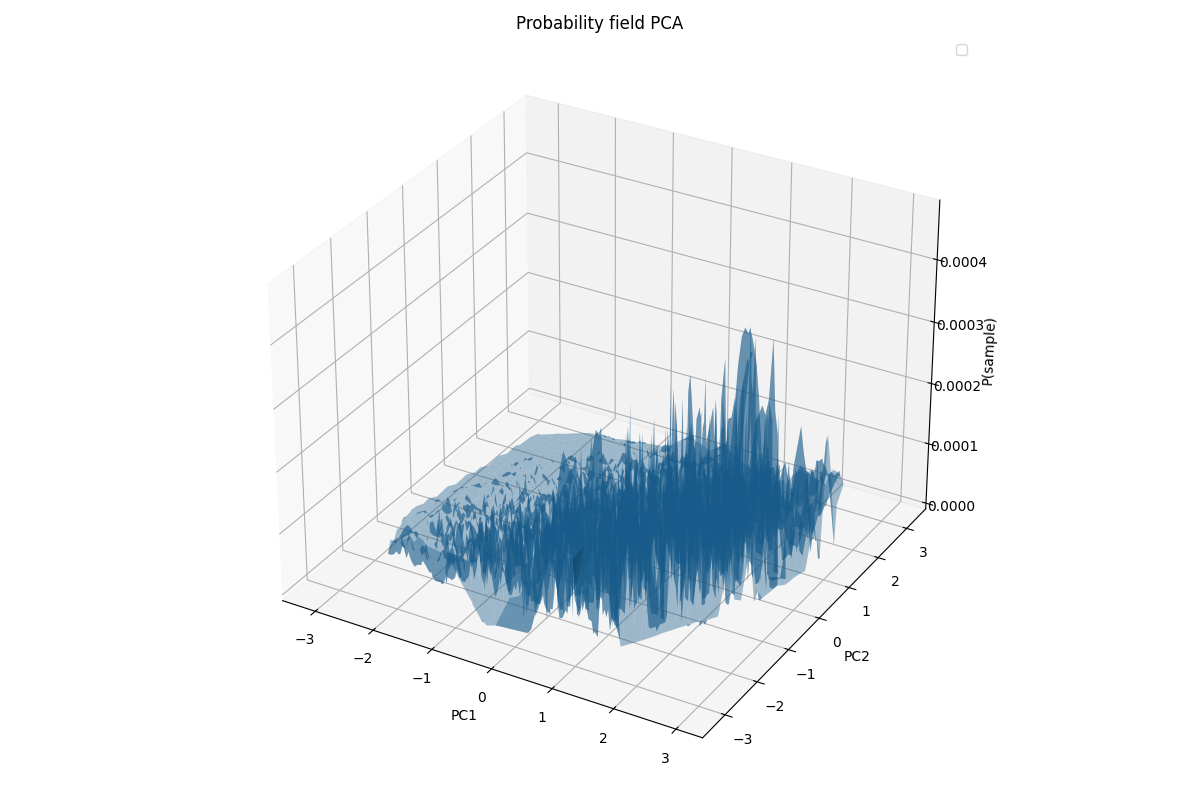

Explained variance ratio: PC1=11.03%, PC2=11.02%
                                  feature  loading_PC1(dir)  loading_PC2(dir)  loading_PC1(corr-style)  loading_PC2(corr-style)
                Geekbench multicore score          0.630353         -0.198343                 0.636747                -0.200299
          front camera resolution (in MP)         -0.503123          0.157962                -0.508226                 0.159520
  rear camera longest focal length (in x)         -0.393005          0.027571                -0.396991                 0.027843
                                      RAM         -0.383382         -0.442220                -0.387271                -0.446580
                  screen size (in inches)         -0.171910         -0.012389                -0.173654                -0.012512
battery life (in hours of video playback)          0.124230          0.456974                 0.125490                 0.461480
 rear camera main lens resolution (in MP)         -0.04

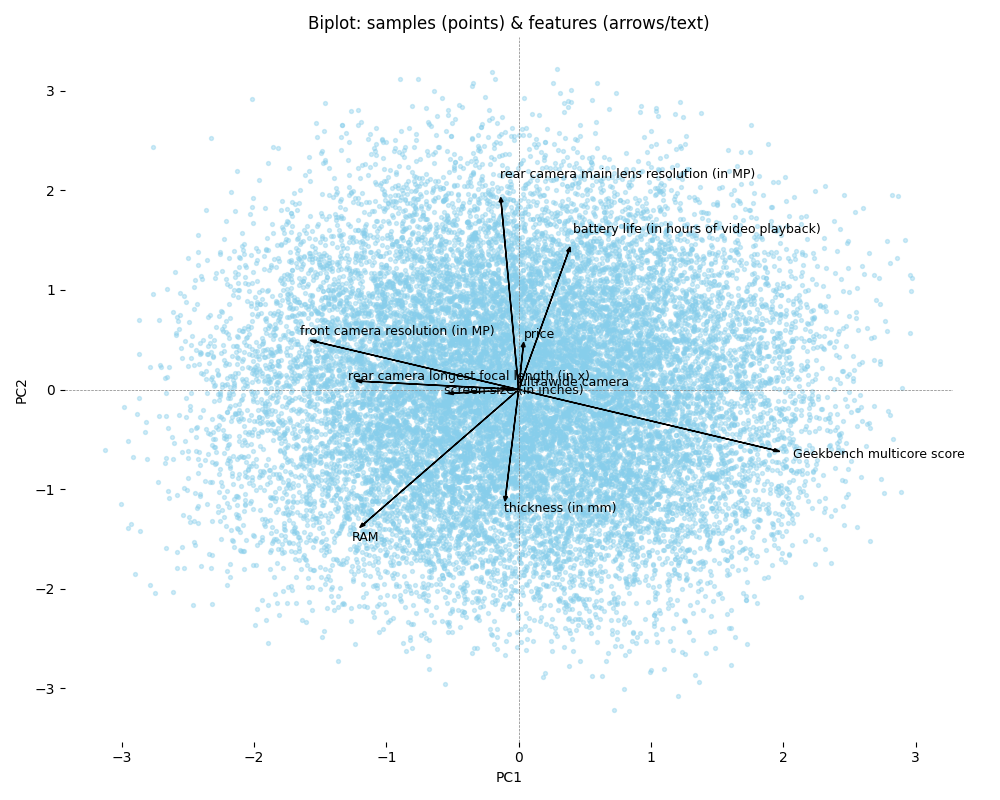

In [5]:
# ==== 5) visualization for training set ====
pca_train, probs_train, scores_train = visualize_probability_distribution(model, X, T, fig_name=f"3d_plot_0_PCA_train{processes}_{ScoreModel}.png")
feature_names = profiles.columns.tolist()
visualize_pca_features(pca_train, X, feature_names)

/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].apply(lambda x: x.astype('category').cat.codes)
/Users/jingyi/Research/FYP/LLM/conjoint_openai/Belif-Elicitation-on-LLM-postrelease/analysis/analysis_pkg/preprocess.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.transform(X[num_cols])


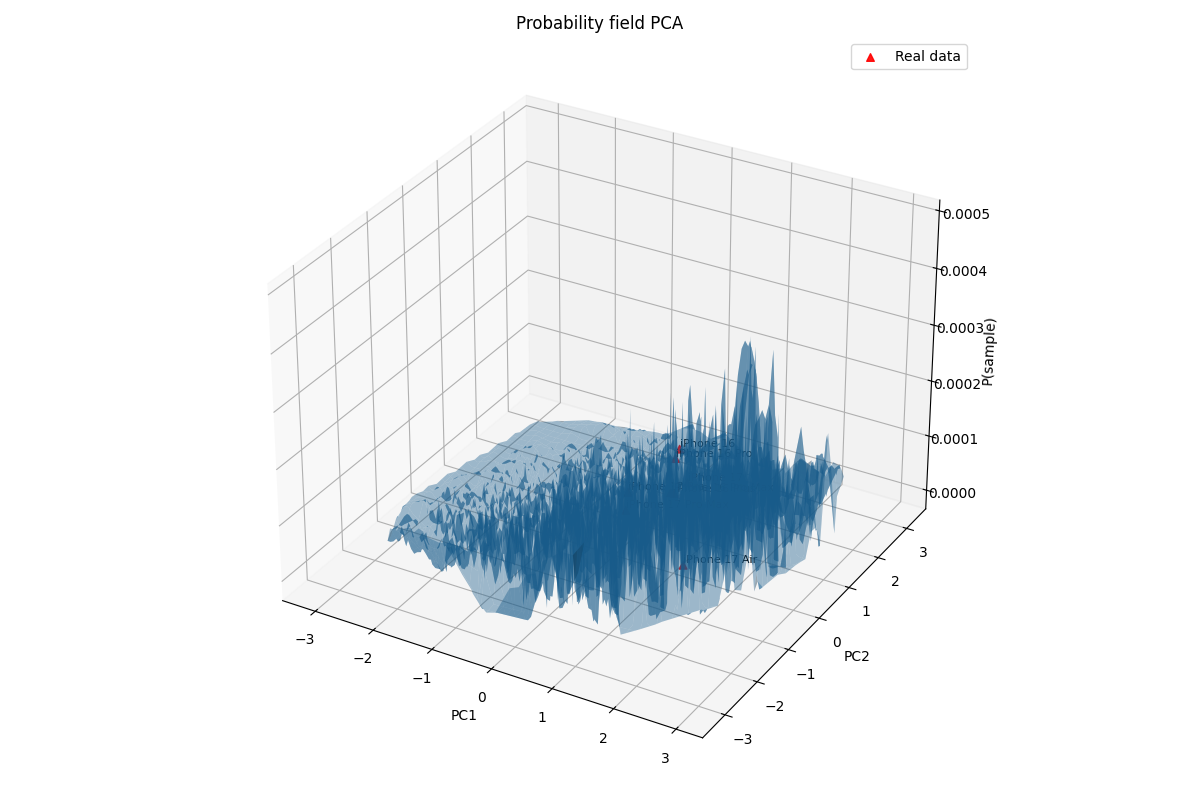

In [6]:
# ==== 6) test on real profiles ====
df_real = pd.read_csv("../data/real_profiles.csv")
X_test = df_real[profiles.columns]
X_test = preprocess_test(X_test)
test_idx = df_real["real model"].tolist()
_, probs, scores = visualize_probability_distribution(
    model, torch.cat([X, X_test], dim=0), T, num_test=X_test.shape[0], test_idx=test_idx, fig_name=f"3d_plot_8_PCA_train{processes}_{ScoreModel}.png"
)

In [7]:
# print the most likely profile
print(profiles.iloc[scores.argmax()])
print('score: ',scores.max())
print("\n====real profiles====\n")
ranks = scores.argsort()[::-1]
for p, i in zip(range(len(ranks)-8, len(ranks)), test_idx):
    rank = np.where(ranks==p)[0][0]+1
    print(f"{i}'s score: {scores[p]:.2f}, rank: {rank}/{len(ranks)}, percentile: {100*(len(ranks)-rank)/len(ranks):.2f}%")

battery life (in hours of video playback)        18.0
screen size (in inches)                           6.1
thickness (in mm)                                 8.8
front camera resolution (in MP)                  11.0
rear camera main lens resolution (in MP)         36.0
rear camera longest focal length (in x)           3.0
ultrawide camera                             equipped
Geekbench multicore score                      8600.0
RAM                                                 4
price                                           959.0
Name: 15941, dtype: object
score:  1.9200605

====real profiles====

iPhone 16's score: 1.32, rank: 320/20008, percentile: 98.40%
iPhone 16 Plus's score: 0.89, rank: 1533/20008, percentile: 92.34%
iPhone 16 Pro's score: 1.20, rank: 525/20008, percentile: 97.38%
iPhone 16 Pro Max's score: 0.76, rank: 2165/20008, percentile: 89.18%
iPhone 17's score: 1.04, rank: 958/20008, percentile: 95.21%
iPhone 17 Air's score: -1.58, rank: 13457/20008, percentile: 32.74%

In [8]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0146, -0.2330,  0.1549, -0.2755, -0.3262, -0.1474, -2.0947,  0.1454,
                       -0.1284,  0.0382]])),
             ('linear.bias', tensor([0.2812]))])

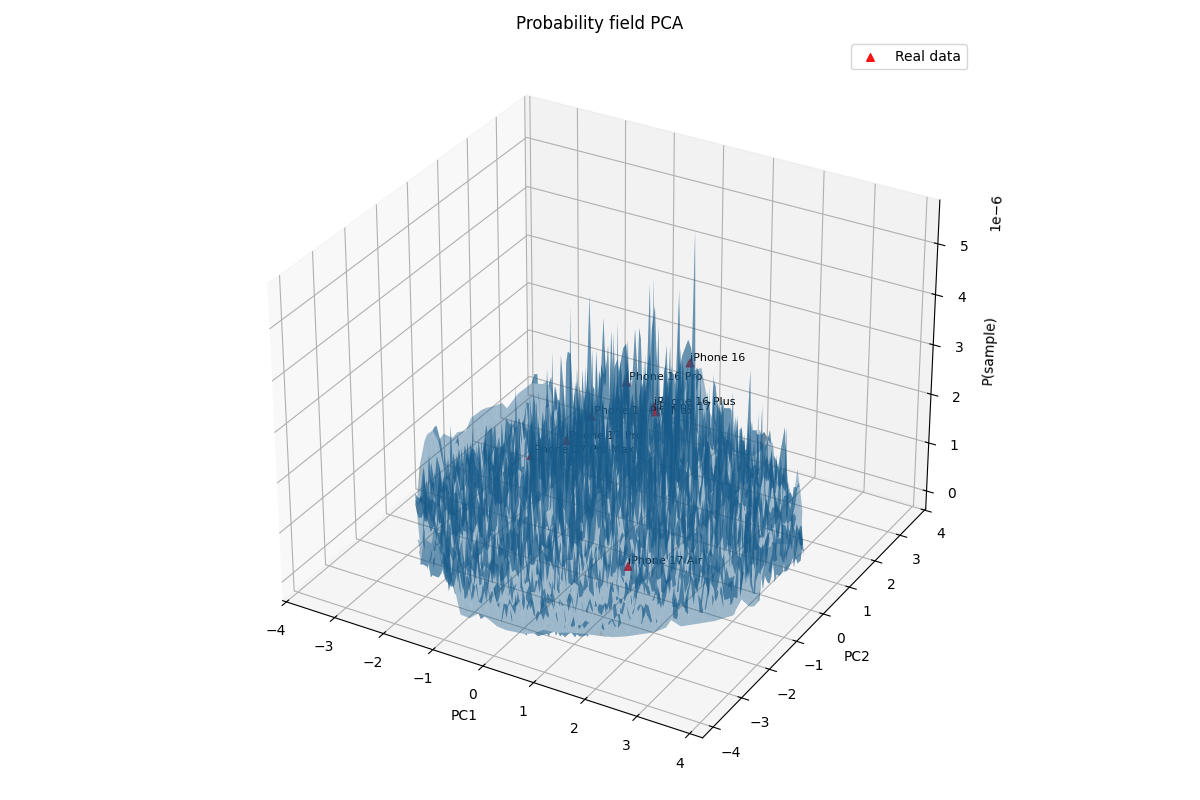

In [9]:
all_profiles = preprocess(profiles)
_, probs, scores = visualize_probability_distribution(
    model, torch.cat([all_profiles, X_test], dim=0), T, num_test=X_test.shape[0], test_idx=test_idx, fig_name=f"3d_plot_ALL_PCA_train{processes}_{ScoreModel}.png"
)

In [10]:
# print the most likely profile
print(profiles.iloc[scores.argmax()])
print('score: ',scores.max())
print("\n====real profiles====\n")
ranks = scores.argsort()[::-1]
for p, i in zip(range(len(ranks)-8, len(ranks)), test_idx):
    rank = np.where(ranks==p)[0][0]+1
    print(f"{i}'s score: {scores[p]:.2f}, rank: {rank}/{len(ranks)}, percentile: {100*(len(ranks)-rank)/len(ranks):.2f}%")

battery life (in hours of video playback)        41.0
screen size (in inches)                           6.1
thickness (in mm)                                 9.0
front camera resolution (in MP)                  12.0
rear camera main lens resolution (in MP)         32.0
rear camera longest focal length (in x)           1.0
ultrawide camera                             equipped
Geekbench multicore score                      9483.0
RAM                                                 4
price                                          1134.0
Name: 899046, dtype: object
score:  2.288817

====real profiles====

iPhone 16's score: 1.32, rank: 24333/1536008, percentile: 98.42%
iPhone 16 Plus's score: 0.89, rank: 112810/1536008, percentile: 92.66%
iPhone 16 Pro's score: 1.20, rank: 40790/1536008, percentile: 97.34%
iPhone 16 Pro Max's score: 0.76, rank: 158714/1536008, percentile: 89.67%
iPhone 17's score: 1.04, rank: 72366/1536008, percentile: 95.29%
iPhone 17 Air's score: -1.58, rank: 1034487/153